# Monte Carlo Localisation

## Hintergrund

Die Monte Carlo Lokalisierung (MCL) ist ein probabilistischer Ansatz zur Schätzung der Pose (Position und Orientierung) eines Roboters in seiner Umgebung. 

### Schlüsselkonzept

Um die Pose des Roboters zu schätzen, verwendet MCL eine Menge von Partikeln, die zufällig im Pose-Raum des Roboters verteilt sind. Jeder Partikel repräsentiert eine mögliche Pose des Roboters und wird anhand von Sensorinformationen aktualisiert, um die tatsächliche Pose des Roboters besser anzunähern. 

### Resampling

Die Partikel werden nach jeder Bewegung des Roboters neu gewichtet und neu verteilt. Partikel mit höheren Gewichtungen werden wahrscheinlicher dupliziert, während Partikel mit niedrigeren Gewichtungen wahrscheinlicher entfernt werden. Dieser Prozess wird als Resampling bezeichnet.

### Implementierung

In dieser Übung implementieren wir die Monte Carlo Lokalisierung in Python. 
Hierbei wird die Kernfunktionalität in der Klasse `MonteCarloLocalization` implementiert.
Diese besitzt die folgenden von ihnen zu implementierenden Methoden:

- `move`: Bewegt die Partikel entsprechend der Bewegung des Roboters. Wenn ein Partikel den Rand der Welt überschreitet, sollte er auf der gegenüberliegenden Seite wieder erscheinen.
- `sense`: Berechnet die Distanz zwischen den Partikeln und den Landmarken und aktualisiert dann die Gewichtungen der Partikel.
- `resample`: Tauscht die Partikel entsprechend ihrer Gewichtungen aus.
- `redistribute`: Verteilt einige Partikel (`self.new_particles`) in die unerforschten Bereiche.

### Weitere Klassen

- `Map`: Stellt die Umgebung des Roboters dar und enthält die Landmarken. Die Methode `sense` berechnet die Distanzen zwischen den Landmarken und der wahren Position des Roboters.
- `Agent`: Stellt den Roboter dar und enthält die Methode `move`, um den Roboter zu bewegen und die Methode `sense`, um die Distanzen zu den Landmarken zu berechnen.

## Aufgabe

Implementieren sie die Methoden `move`, `sense`, `resample` und `redistribute` in der Klasse `MonteCarloLocalization`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MonteCarloLocalization:

    def __init__(self, num_particles, map_):
        """
        :param num_particles: number of particles
        :param map_: Map object
        """
        self.num_particles = num_particles
        self.new_particles = num_particles // 10
        self.map = map_
        self.world_size = map_.world_size
        self.particles, self.orientations, self.weights = self._init_particles(num_particles)


    def _init_particles(self, num_particles):
        """
        :param num_particles: number of particles to generate
        :return: particles, orientations, weights
        """
        # positions, orientations (angles) and weights of the particles
        particles = np.random.uniform(0, self.world_size, size=(num_particles, 2))
        weights = np.ones(num_particles) / num_particles
        orientations = np.random.uniform(0, 2 * np.pi, size=num_particles)
        return particles, orientations, weights


    def get_estimated_position(self):
        """
        returns the estimated position of the agent
        """
        return np.median(self.particles, axis=0)


    def move(self, motion):
        """
        moves the particles according to the motion
        if the particle goes out of the world, it should reappear on the other side
        :param motion: (step_size, angle) tuple
        """
        # TODO: your code here
        pass


    def _particle_distance(self, particle, measurement):
        """
        :param particle: 1x2 array
        :param measurement: (num_landmarks, 2) array
        returns the distance of the partcle measurement to the actual measurement
        """
        particle_measurement = self.map.sense(particle)
        return np.linalg.norm(particle_measurement - measurement)


    def _normalize(self, weights):
        return weights / np.sum(weights)


    def redistribute(self):
        """
        redistribute some particles (#self.new_particles) to the unexplored areas
        """
        # TODO: your code here
        pass


    def sense(self, measurement):
        """
        calculates the probability of each particle given the measurement
        and then updates the weights of the particles
        :param measurement: (num_landmarks, 2) array
        """
        # TODO: your code here
        # your can use the _measurement_prob, _particle_distance and _normalize methods.
        pass


    def resample(self):
        """
        resamples the particles according to their weights
        """
        # TODO: your code here
        pass


    def _measurement_prob(self, distance):
        prob = 1.0 / (distance + 1e-6)  # Add a small epsilon to avoid division by zero
        return prob


    def localize(self, motion, measurement):
        self.move(motion)
        self.sense(measurement)
        self.resample()
        self.redistribute()

In [3]:
class Map:

    def __init__(self, world_size, view_radius, num_landmarks):
        self.world_size = world_size
        self.landmarks = self.generate_landmarks(num_landmarks)
        self.view_radius = view_radius


    def generate_landmarks(self, num_landmarks):
        return np.random.uniform(0, self.world_size, size=(num_landmarks, 2))


    def sense(self, true_position):
        """
        :param true_position: (2,) array
        return the distances to the landmarks plus some noise.
        If the landmark is not in the view radius, set the distance to infinity
        """
        distances = np.linalg.norm(self.landmarks - true_position, axis=1)
        noised_distances = distances + np.random.normal(0, 2, size=len(distances))

        # set not viewable landmarks to infinity
        noised_distances[distances > self.view_radius] = self.world_size
        return noised_distances


class Agent:

    def __init__(self, world_size):
        self.pos = np.random.uniform(0, world_size, size=2)
        self.orientation = np.random.uniform(0, 2 * np.pi)
        self.world_size = world_size


    def move(self, step_size, angle):
        self.orientation += angle
        self.orientation %= 2 * np.pi
        self.pos += np.array([step_size * np.cos(self.orientation),
                             step_size * np.sin(self.orientation)])
        self.pos %= self.world_size


    def sense(self, map_):
        return map_.sense(self.pos)

# Beispielergebnis

Hier ist ein Beispielergebnis, das Sie erwarten können, wenn Sie die Implementierung korrekt durchgeführt haben:

![mcl](mcl_example.png)

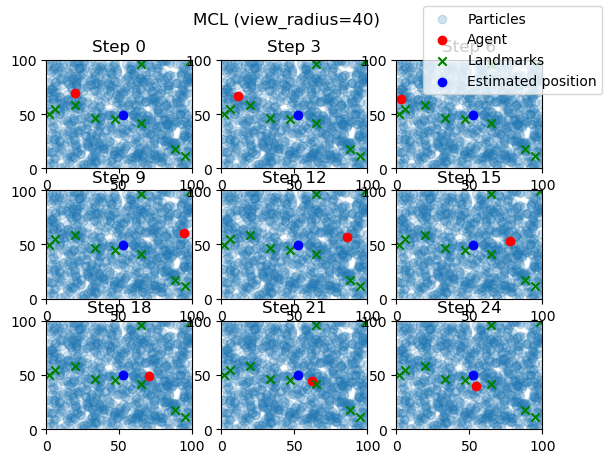

In [4]:
def simulate(steps, map_, num_particles=1000):

    # Example usage:
    agent = Agent(map_.world_size)
    mc_localization = MonteCarloLocalization(num_particles, map_)

    for _ in range(steps):
        agent.move(3, 0.01)
        measurement = agent.sense(map_)
        mc_localization.localize((3, 0.01), measurement)
        estimated_position = mc_localization.get_estimated_position()
        yield agent.pos, mc_localization.particles, estimated_position

    print(f"Estimated position: {estimated_position}")
    print(f"True position: {agent.pos}")


def visualize():
    # simulation config
    view_radius = 40
    world_size = 100
    num_landmarks = 10
    steps = 30
    plot_every = steps // 9
    map_ = Map(world_size, view_radius, num_landmarks)

    # visualization
    fig, axs = plt.subplots(3, 3)

    ax_idx = 0
    for i, (pos, particles, estimated_position) in enumerate(simulate(steps, map_)):
        if i % plot_every != 0:
            continue

        if ax_idx >= 9:
            break

        ax = axs[ax_idx // 3, ax_idx % 3]
        ax.scatter(particles[:, 0], particles[:, 1], alpha=0.2)
        ax.scatter(pos[0], pos[1], c='r', marker='o')
        ax.scatter(map_.landmarks[:, 0], map_.landmarks[:, 1], c='g', marker='x')
        ax.scatter(estimated_position[0], estimated_position[1], c='b', marker='o')
        ax.set_title(f"Step {i}")
        ax.set_xlim(0, world_size)
        ax.set_ylim(0, world_size)

        ax_idx += 1

    fig.legend(['Particles', 'Agent', 'Landmarks', 'Estimated position'], loc='upper right')
    plt.suptitle(f"MCL (view_radius={view_radius})")
    plt.show()


if __name__ == "__main__":
    visualize()